# Keyword Minimap Visualizer

可視化長篇文本中的關鍵字分布：
- 依段切分主文本並支援多檔比較
- 熱圖採 Turner 漸層呈現全篇密度，可切換白色格線
- 逐詞趨勢線改用 Blossom 粉系，突出多文件差異


In [43]:
from pathlib import Path
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
from matplotlib.colors import LinearSegmentedColormap

%matplotlib inline

sns.set_theme(style='white', context='talk')

pd.options.display.max_rows = 20
pd.options.display.max_columns = 20

# ===== 字型設定 =====
fonts_dir = Path('fonts')
custom_font_path = Path('fonts/PingFang.ttc')

matched_font = None
fallback_names = []

def register_font(path: Path):
    try:
        fm.fontManager.addfont(str(path))
        return fm.FontProperties(fname=str(path)).get_name()
    except Exception:
        return None

if custom_font_path is not None:
    resolved = custom_font_path if custom_font_path.is_absolute() else (fonts_dir / custom_font_path.name)
    resolved = resolved.resolve()
    if resolved.exists():
        name = register_font(resolved)
        if name:
            matched_font = fm.FontProperties(fname=str(resolved))
            print(f'使用自訂字型檔：{resolved}')
        else:
            print(f'⚠️ 無法註冊字型檔：{resolved}')
    else:
        print(f'⚠️ 指定的字型檔不存在：{resolved}')

if matched_font is None and fonts_dir.exists():
    for pattern in ('*.ttc', '*.otf', '*.ttf'):
        for fp in sorted(fonts_dir.glob(pattern)):
            name = register_font(fp.resolve())
            if not name:
                continue
            if matched_font is None:
                matched_font = fm.FontProperties(fname=str(fp.resolve()))
                print(f'使用 fonts/ 中的字型：{fp}')
            else:
                fallback_names.append(name)
        if matched_font:
            break

if matched_font is None:
    font_keywords = [
        'noto sans cjk', 'noto sans tc', 'source han sans', 'sourcehansans',
        'pingfang', 'heiti', 'microsoft jhenghei', 'taipei sans',
        'wenquanyi', 'wen quan yi', 'sarasa', 'ipaex gothic', 'ipaexg',
        'lxgw', 'kaiti', 'kaiu', 'simhei', 'simsun', 'fangsong'
    ]
    for font in fm.fontManager.ttflist:
        name_lower = font.name.lower()
        path_lower = Path(font.fname).stem.lower()
        if any(keyword in name_lower or keyword in path_lower for keyword in font_keywords):
            matched_font = fm.FontProperties(fname=font.fname)
            print(f'使用環境內可用字型：{font.fname}')
            break

if matched_font:
    font_name = matched_font.get_name()
    plt.rcParams['font.family'] = [font_name] + fallback_names
    plt.rcParams['font.sans-serif'] = [font_name] + fallback_names
    print(f'最終採用字型：{font_name}')
    if fallback_names:
        print('備用字型：', ', '.join(fallback_names))
else:
    print('⚠️ 找不到可用的中文字型，請將字型檔放到 fonts/ 或手動指定 custom_font_path。')

plt.rcParams['axes.unicode_minus'] = False


使用自訂字型檔：/home/jovyan/fonts/PingFang.ttc
最終採用字型：PingFang HK


## 1. 設定：檔案路徑、關鍵字與視覺化參數
- `text_path`：要分析的純文字檔（支援 Markdown／TXT 等）。
- `keywords`：要追蹤的關鍵字清單；支援中英文、大小寫不敏感。
- `n_segments`：把全文切成幾個片段來評估關鍵字出現密度。數值越大，解析度越細。

In [44]:
# --- 使用者可調整區域 ---
# 將 text_path 設為特定檔案路徑；若設為 None 則會自動尋找相對應檔案
text_path = None
keywords = [
    '聲請人一',
    '聲請人二',
    '主文',
    '遺產稅',
    '憲法',
    '平等權',
    '自由權',
    '財產權',
    '繼承權',
    '審查',
    '標準',
    '量能課稅',
    '比例原則',
    '絞殺',
    '半數'
]

# 分段數量；200~400 會有不錯的解析度，也視文本長度調整
n_segments = 200

# 是否將每個關鍵字的出現次數做 0~1 的標準化，方便比較不同頻率的字
normalize_per_keyword = True

# 是否在熱圖上繪製白色網格線
heatmap_show_grid = True

# # 額外比較的文本路徑，可為絕對或相對路徑。
# comparison_paths = [
#     Path('mkdocs/My_Notes/113憲判字11號判決/法官學院講初稿.md'),
# ]

# 額外比較的文本路徑，可為絕對或相對路徑。留空則僅分析主要文本。
comparison_paths = [
    Path('mkdocs/My_Notes/113憲判字11號判決/法官學院講初稿.md'),
]


## 2. 載入文本並切割成可視化片段

In [45]:
possible_roots = []
wd = Path.cwd()
possible_roots.append(wd)
possible_roots.append(wd / 'work')
possible_roots.extend(wd.parents)
possible_roots.extend((wd / 'work').parents)

def resolve_path(candidate):
    if candidate is None:
        return None
    p = Path(candidate)
    if p.is_absolute():
        return p if p.exists() else None
    for base in possible_roots:
        test_path = (Path(base) / p).resolve()
        if test_path.exists():
            return test_path
    return None

resolved_text_path = None
if text_path is not None:
    resolved_text_path = resolve_path(text_path)
else:
    defaults = [
        Path('mkdocs/My_Notes/113憲判字11號判決/法官學院書面稿.md'),
        Path('法官學院書面稿.md')
    ]
    for default in defaults:
        resolved_text_path = resolve_path(default)
        if resolved_text_path:
            break

if resolved_text_path is None:
    raise FileNotFoundError('找不到目標檔案，請檢查 text_path 設定或調整 possible_roots。')

print(f'讀取完成：{resolved_text_path}')
raw_text = resolved_text_path.read_text(encoding='utf-8', errors='ignore')
num_chars = len(raw_text)
num_lines = raw_text.count('\n') + 1
print(f'字元數：{num_chars:,}，行數：約 {num_lines:,} 行')

n_segments = max(10, n_segments)
segment_size = math.ceil(num_chars / n_segments)
segments = [
    raw_text[i:i + segment_size] for i in range(0, num_chars, segment_size)
]
segment_positions = np.linspace(0, 100, num=len(segments), endpoint=False)
print(f'實際切割為 {len(segments)} 個片段（每片段約 {segment_size:,} 字元）')


讀取完成：/home/jovyan/work/mkdocs/My_Notes/113憲判字11號判決/法官學院書面稿.md
字元數：29,454，行數：約 1,113 行
實際切割為 200 個片段（每片段約 148 字元）


## 3. 統計每個片段的關鍵字命中次數

In [46]:
if not keywords:
    raise ValueError('請至少指定一個關鍵字。')

compiled_patterns = {
    kw: re.compile(re.escape(kw), re.IGNORECASE)
    for kw in keywords
}

def compute_counts(segment_list):
    counts = []
    for kw in keywords:
        pattern = compiled_patterns[kw]
        counts.append([len(pattern.findall(seg)) for seg in segment_list])
    counts_array = np.array(counts, dtype=float)
    df = pd.DataFrame(counts_array.T, columns=keywords)
    return counts_array, df

def prepare_viz_array(counts_array):
    if normalize_per_keyword:
        max_per_kw = counts_array.max(axis=1, keepdims=True)
        max_per_kw[max_per_kw == 0] = 1
        return counts_array / max_per_kw
    return counts_array

counts_array, counts_df = compute_counts(segments)
viz_array = prepare_viz_array(counts_array)
segment_index = pd.Index(range(1, len(segments) + 1), name='segment')
counts_df.index = segment_index
summary_df = counts_df.sum(axis=0).sort_values(ascending=False).to_frame('total_hits')
summary_df['avg_per_segment'] = counts_df.mean(axis=0)
summary_df


,total_hits,avg_per_segment
憲法,110.0,0.550
審查,110.0,0.550
財產權,78.0,0.390
遺產稅,74.0,0.370
平等權,71.0,0.355
自由權,53.0,0.265
繼承權,34.0,0.170
量能課稅,34.0,0.170
比例原則,31.0,0.155
主文,29.0,0.145


In [47]:
documents = []

def build_document_record(path):
    raw_text_local = path.read_text(encoding='utf-8', errors='ignore')
    num_chars_local = len(raw_text_local)
    segment_size_local = max(1, math.ceil(num_chars_local / n_segments))
    segments_local = [
        raw_text_local[i:i + segment_size_local]
        for i in range(0, num_chars_local, segment_size_local)
    ]
    counts_array_local, counts_df_local = compute_counts(segments_local)
    counts_df_local.index = range(1, len(segments_local) + 1)
    percent_positions = np.linspace(0, 100, num=len(segments_local))
    viz_local = prepare_viz_array(counts_array_local)
    return {
        'path': path,
        'label': path.name,
        'segments': segments_local,
        'positions': percent_positions,
        'counts_df': counts_df_local,
        'counts_array': counts_array_local,
        'viz_array': viz_local
    }

primary_doc = build_document_record(resolved_text_path)
documents.append(primary_doc)

comparison_docs = []
for candidate in comparison_paths:
    resolved = resolve_path(candidate)
    if resolved:
        try:
            comparison_docs.append(build_document_record(resolved))
        except Exception as err:
            print(f'⚠️ 無法處理 {resolved}: {err}')
    else:
        print(f'⚠️ 找不到比較用檔案：{candidate}')

if comparison_docs:
    documents.extend(comparison_docs)
    print('已載入比較文本：', ', '.join(doc['label'] for doc in comparison_docs))

counts_df = primary_doc['counts_df']
counts_array = primary_doc['counts_array']
viz_array = primary_doc['viz_array']
segments = primary_doc['segments']
segment_positions = primary_doc['positions']
segment_index = pd.Index(range(1, len(segments) + 1), name='segment')


已載入比較文本： 法官學院講初稿.md


## 4. 關鍵字分布熱圖（Minimap 風格）

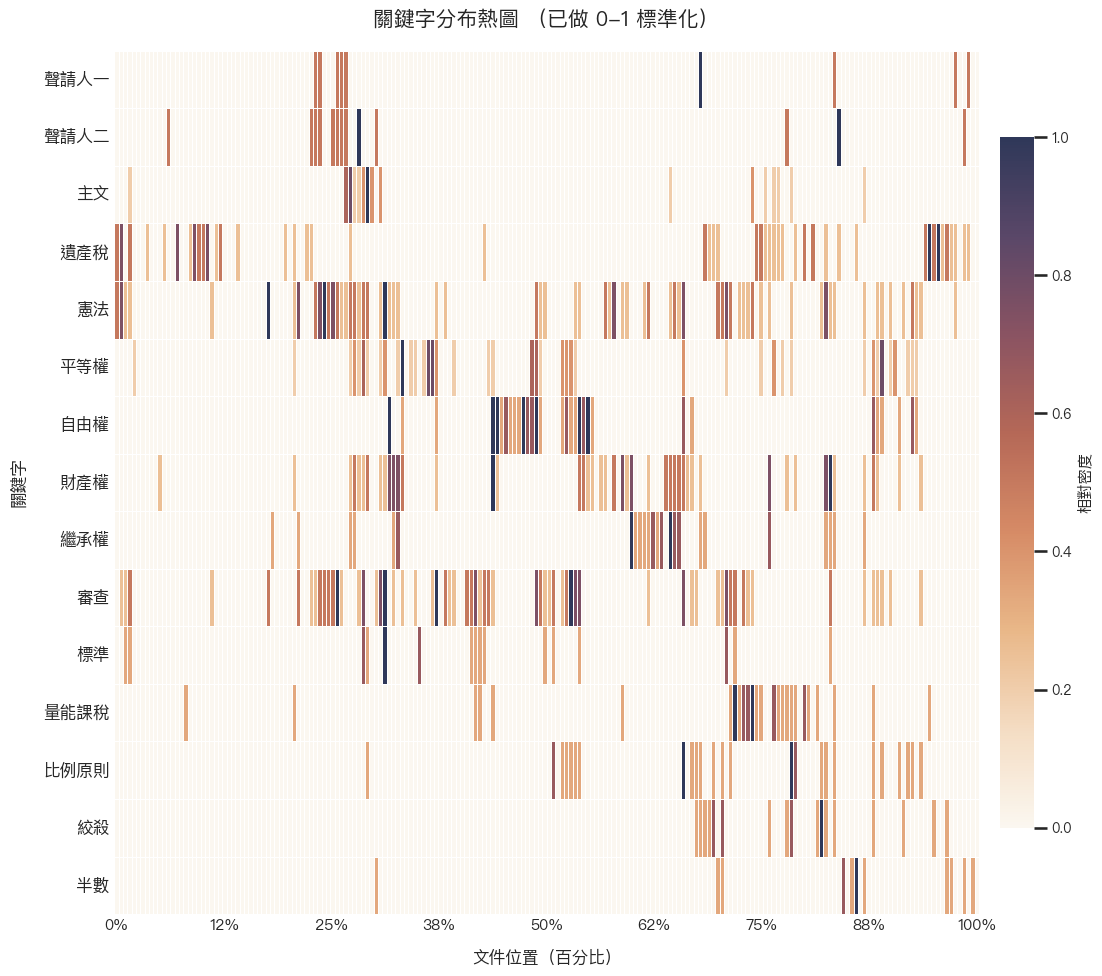

In [48]:
turner_cmap = LinearSegmentedColormap.from_list(
    'turner_soft',
    [
        '#fbf7f0', '#f4dcc2', '#e9b788', '#d68b66',
        '#b56857', '#8a5362', '#5a4768', '#2f3859'
    ]
)

if 'viz_array' not in globals():
    viz_array = prepare_viz_array(counts_array)

heatmap_df = pd.DataFrame(viz_array, index=keywords, columns=range(len(segments)))
fig_height = max(3.2, 0.58 * len(keywords) + 1.4)
fig, ax = plt.subplots(figsize=(12, fig_height))
sns.heatmap(
    heatmap_df,
    ax=ax,
    cmap=turner_cmap,
    cbar=True,
    cbar_kws={'pad': 0.02, 'shrink': 0.8},
    xticklabels=False,
    yticklabels=keywords,
    linewidths=0.6 if heatmap_show_grid else 0,
    linecolor='white' if heatmap_show_grid else None,
    square=False,
    vmin=0,
    vmax=heatmap_df.values.max() if not normalize_per_keyword else 1
)
tick_count = min(9, len(segments)) if len(segments) > 1 else 1
positions = np.linspace(0, len(segments) - 1, num=tick_count)
labels = [f'{p:.0f}%' for p in np.linspace(0, 100, num=tick_count)] if tick_count > 1 else ['0%']
ax.set_xticks(positions + 0.5)
ax.set_xticklabels(labels, rotation=0, ha='center', fontsize=11)
ax.set_yticklabels(keywords, fontsize=12)
ax.set_xlabel('文件位置（百分比）', fontsize=12, labelpad=12)
ax.set_ylabel('關鍵字', fontsize=12, labelpad=12)
title_suffix = '（已做 0-1 標準化）' if normalize_per_keyword else '（實際出現次數）'
ax.set_title(f'關鍵字分布熱圖 {title_suffix}', fontsize=15, pad=18)
ax.set_facecolor('#fdfbf7')
for spine in ax.spines.values():
    spine.set_visible(False)
cbar = ax.collections[0].colorbar
cbar_label = '相對密度' if normalize_per_keyword else '出現次數'
cbar.set_label(cbar_label, fontsize=11)
cbar.ax.tick_params(labelsize=10)
ax.tick_params(axis='both', length=0)
plt.tight_layout()
plt.show()


## 5. 逐詞趨勢（每份文件）
比較各關鍵字在不同文件中的原始段落頻次。

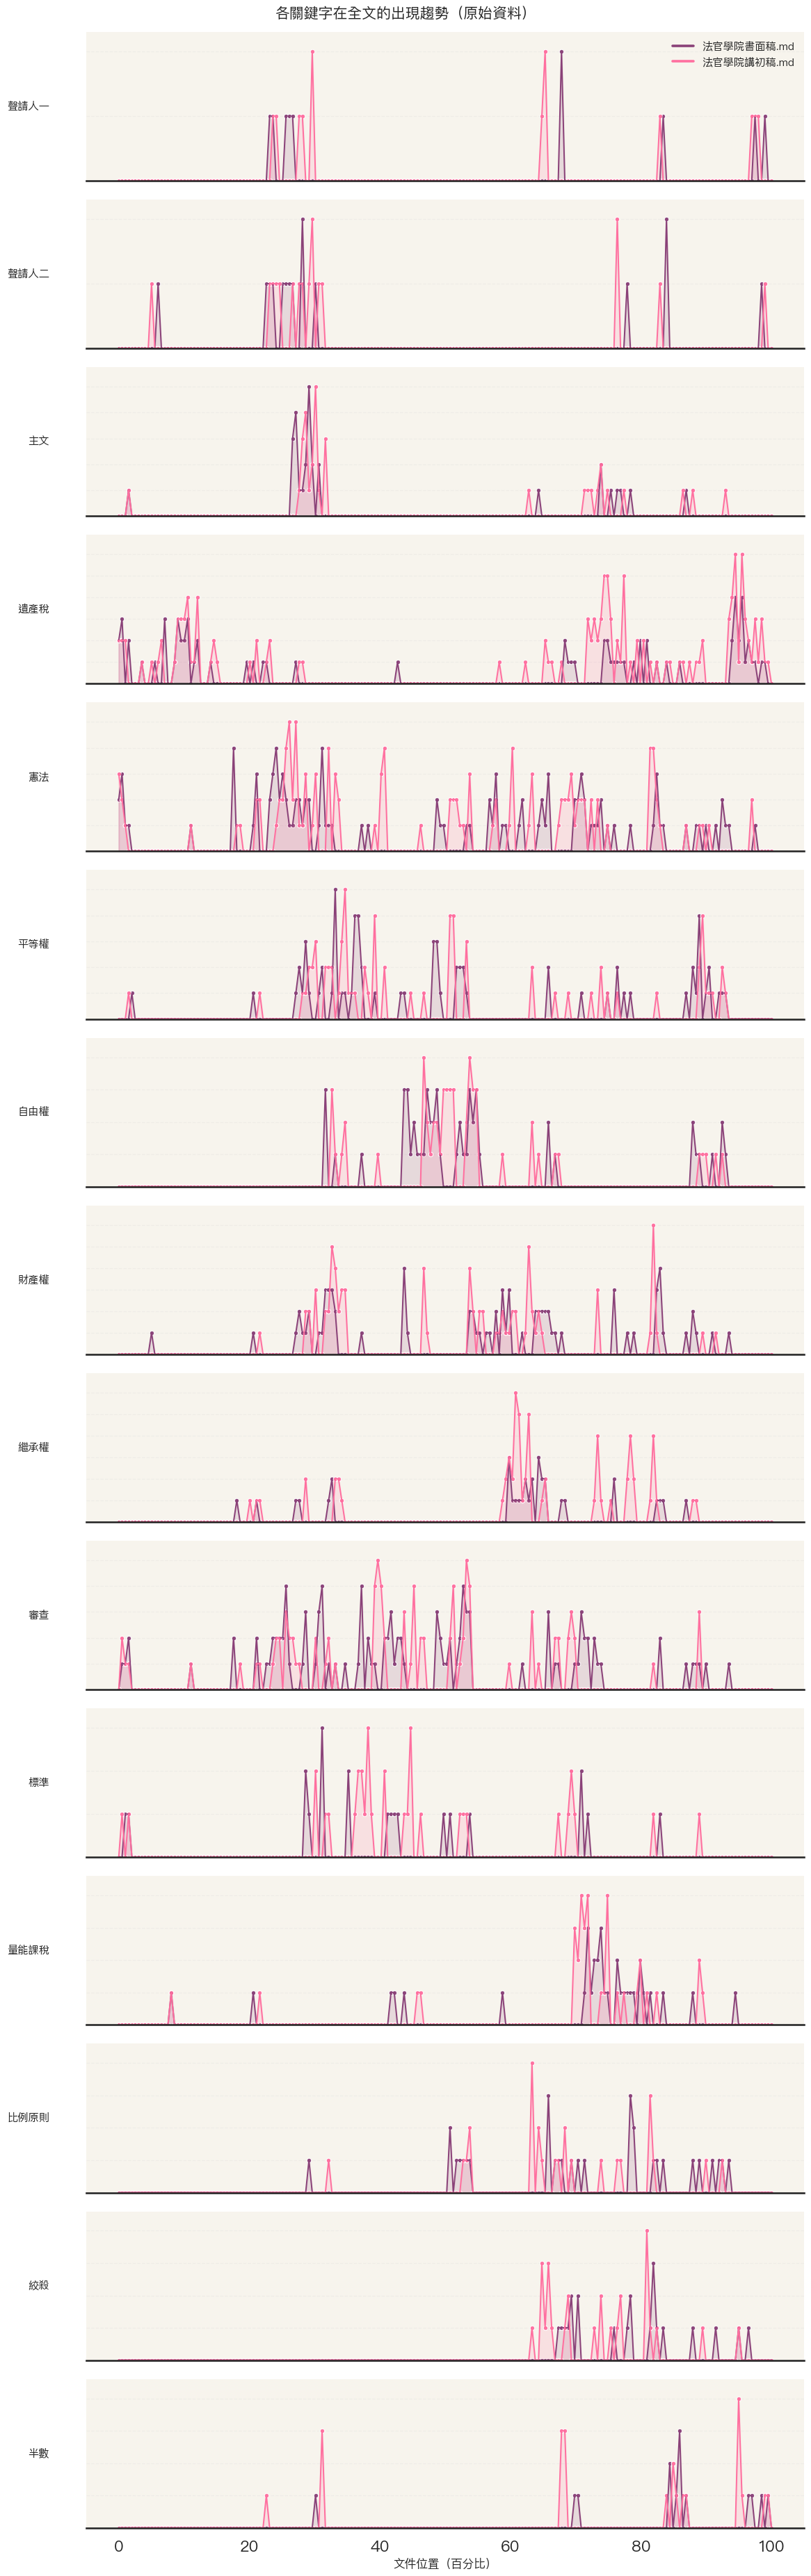

In [49]:
blossom_line_colors = ['#8a4178', '#ff8ab6', '#ff6f9f', '#f05a8f', '#ffb3d0', '#ffd7e5', '#fff6f8']
color_order = [0, 2, 4, 1, 3, 5, 6]
colors = [blossom_line_colors[i % len(blossom_line_colors)] for i in color_order[:max(1, len(documents))]]

fig, axes = plt.subplots(len(keywords), 1, figsize=(12, 2.5 * len(keywords)), sharex=True)
if len(keywords) == 1:
    axes = [axes]

for ax, kw in zip(axes, keywords):
    ax.set_facecolor('#f7f4ed')
    max_val = 0
    for idx, doc in enumerate(documents):
        color = colors[idx % len(colors)]
        positions = doc['positions']
        series = doc['counts_df'][kw].astype(float).to_numpy()
        ax.plot(positions, series, color=color, linewidth=1.4, label=doc['label'])
        ax.fill_between(positions, series, alpha=0.15, color=color)
        ax.scatter(positions, series, color=color, s=22, edgecolor='white', linewidth=0.8, alpha=0.95)
        max_val = max(max_val, series.max())
    ax.set_ylabel(kw, rotation=0, labelpad=38, fontsize=11, va='center', ha='right')
    ax.set_ylim(0, max(1, max_val * 1.15))
    ax.set_yticks(range(int(max_val) + 1))
    ax.grid(axis='y', alpha=0.18, linestyle='--', linewidth=0.9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='y', which='both', left=False, labelleft=False)

axes[-1].set_xlabel('文件位置（百分比）', fontsize=12)
fig.suptitle('各關鍵字在全文的出現趨勢（原始資料）', fontsize=15, y=0.99)

handles = [plt.Line2D([0], [0], color=colors[idx % len(colors)], lw=2.6) for idx in range(len(documents))]
labels = [doc['label'] for doc in documents]
axes[0].legend(handles, labels, loc='upper right', frameon=False, fontsize=11)

plt.tight_layout()
plt.show()


## 6. 小結與延伸
- 調整 `n_segments` 可以改變解析度；越大越細緻，但計算時間也會略增。
- `comparison_paths` 可加入多份 Markdown/TXT 以對照各文件線圖。
- 若想進一步互動式檢索，可考慮搭配 `plotly` 或 `altair` 等套件。
- 大型檔案可先壓縮或使用 `mmap`／`numpy.memmap` 讀取。